#Breve descripción del proyecto:

Escogimos el juego de Centipede de atari, la versión 4 ya que la versión 5 no podía correr en colab.

In [5]:
!pip install gym[atari]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.1 MB/s eta 0:00:00


In [1]:
!pip install gym[accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached AutoROM-0.4.2-py3-none-any.whl (16 kB)
  Using cached AutoROM.accept-rom-license-0.6.1.tar.gz (434 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=acb3e66f4101ce1e42a39243607cf4eaa3cd6e359ff4d4fc3dcb541f72fb714e
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [8]:
import gym

env = gym.make('Centipede-v4')


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
#!pip install pytorch

###Primer dificultad con la que nos encontramos:
El vector que de estados que nos regresa el juego es un vector R3 y entonces el problema se vuelve complejo, ergo necesitamos varias capas.

#### Arquitectura:
Capa Inicial ----> función de activación RELU ----> otra capa lineal ---> RELU y finalmente la capa de salida.
¿Por qué? cuando solo teniamos una capa oculta, el puntaje era muy bajo siempre, y decidimos por implementar otra capa para que la transformación ayudara a encontrar una función objetivo "buena".


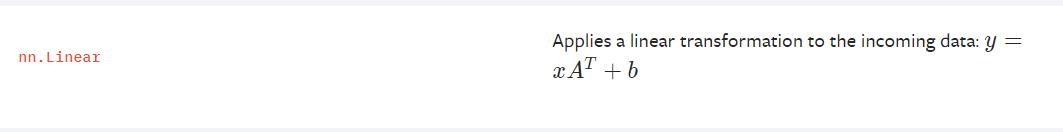

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(QNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, state):
        return self.layers(state)


## Agente
Partes de nuestro agente:


1.   Política: nuestra política fue una politica Epsilon greedy porque queremos explorar diferentes escenarios y no sólo explotar el mayor valor q.


```
def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(action_dim)  # Explorar
        else:
            with torch.no_grad():
                state = torch.tensor(state).float().view(-1)
                q_values = self.q_network(state)
            return np.argmax(q_values.numpy())  # Explotar

```


2.  Función Objetivo: En aprendizaje por refuerzo nuestra función objetico es maximizar la acción que sigue. Utilizamos la fórmula básica de TD learning: V(s) ← V(s) + α * [R + γ * V(s') - V(s)]

```
# Esto es la diferencia cuadrada entre la estimación y el valor de la acción.

loss = ((q_values[action] - target) ** 2).mean()

target = reward + 0.99 * next_q_values * (1 - int(done))

```
el 0.99 es nuestra gamma y de ahi checamos cual seria el valor futuro que se puede tener en el siguiente estado.





In [7]:
class Agent:
    def __init__(self, state_dim, action_dim, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.q_network = QNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.q_network.parameters())
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

    def load_model(self, model_path):
        self.q_network.load_state_dict(torch.load(model_path))
        self.q_network.eval()  

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(action_dim)  # Explorar
        else:
            with torch.no_grad():
                state = torch.tensor(state).float().view(1, -1)
                q_values = self.q_network(state)
            return np.argmax(q_values.numpy())  # Explota
        
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_end  

    def train(self, state, action, reward, next_state, done):
      self.optimizer.zero_grad()
      state = torch.tensor(state).float().view(1, -1)  
      q_values = self.q_network(state)
      with torch.no_grad():
          next_state = torch.tensor(next_state).float().view(1, -1)  
          next_q_values = self.q_network(next_state)
      target = reward + 0.99 * next_q_values * (1 - int(done))

      action = torch.tensor([action]).unsqueeze(0)  
      q_values = q_values.gather(1, action)  

      loss = ((q_values - target) ** 2).mean()
      loss.backward()
      self.optimizer.step()






/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
episodes = 2000000
state_dim = 100800

action_dim = env.action_space.n
agent = Agent(state_dim, action_dim)
#agent.load_model("q_network_best.pth")
consecutive_wins = 0
max_reward=0

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, done, _= env.step(action)
        agent.train(state, action, reward, next_state, done) 
        total_reward += reward
        state = next_state
    if total_reward>max_reward:
      max_reward=total_reward
      torch.save(agent.q_network.state_dict(), f"q_network_best.pth")  
      print(f"New max reward: {max_reward}, model saved.")

    if total_reward > 40000:  
        consecutive_wins += 1
        if consecutive_wins >= 2:  
            print("Achieved back to back wins!")
            break
    else:
        consecutive_wins = 0  
    if episode % 10000 == 0:
        torch.save(agent.q_network.state_dict(), f"q_network_{episode}.pth")
        print(episode)
    agent.decay_epsilon()
    #print("Episode: {}, Score: {}, Consecutive wins: {}".format(episode,total_reward, consecutive_wins))

env.close()


New max reward: 1043.0, model saved.
0
New max reward: 2789.0, model saved.
New max reward: 3315.0, model saved.
New max reward: 4479.0, model saved.
New max reward: 4805.0, model saved.
New max reward: 6274.0, model saved.
New max reward: 9967.0, model saved.
New max reward: 14977.0, model saved.


In [ ]:
episodes = 2000000
state_dim = 100800

action_dim = env.action_space.n
agent = Agent(state_dim, action_dim)
agent.load_model("q_network_best (1).pth")

In [ ]:
episodes = 20
state_dim = 100800

action_dim = env.action_space.n

consecutive_wins = 0
max_reward=0

for episode in range(episodes):
    state = env.reset()[0]
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, done, _,__= env.step(action)
        agent.train(state, action, reward, next_state, done) # Train the agent with the experience
        total_reward += reward
        state = next_state
    agent.decay_epsilon()
    print("Episode: {}, Score: {}, Consecutive wins: {}".format(episode,total_reward, consecutive_wins))

env.close()